# Case Study Five: SVM & SGD
## By: Allen Hoskins & Brittany Lewandowski

In [1]:
#Importing required libraries:
import pandas as pd
import io 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from scipy import stats
import vowpalwabbit as vw
from vowpalwabbit.dftovw import DFtoVW
from vowpalwabbit import Workspace
from sklearn.metrics import log_loss
import warnings

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
log_df = pd.read_csv(r'../data_sets/log2.csv')

In [4]:
#Viewing general data related information:

display(log_df.info())
display(log_df.describe())
display(log_df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


None

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


int64     11
object     1
dtype: int64

In [5]:
#Viewing missing values in our data frame:
log_df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [6]:
#Re-naming columns:
log_df.rename(columns = {'Source Port':'source_port','Destination Port':'destination_port','NAT Source Port':'nat_source_port',
                         'NAT Destination Port':'nat_destination_port','Bytes Sent':'bytes_sent','Bytes Received':'bytes_receieved',
                         'Elapsed Time (sec)':'elapsed_time','Bytes':'bytes','Packets':'packets'},inplace = True)
log_df.head()

,source_port,destination_port,nat_source_port,nat_destination_port,Action,bytes,bytes_sent,bytes_receieved,packets,elapsed_time,pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [7]:
#Converting data types of "Port" columns:

log_df['source_port'] = log_df.source_port.astype('object')
log_df['destination_port'] = log_df.destination_port.astype('object')
log_df['nat_source_port'] = log_df.nat_source_port.astype('object')
log_df['nat_destination_port'] = log_df.nat_destination_port.astype('object')

In [8]:
#Separating data into numeric and categorical columns:

num_df = log_df.select_dtypes(include=np.number)
cat_df = log_df.select_dtypes(include=['object'])

## EDA:

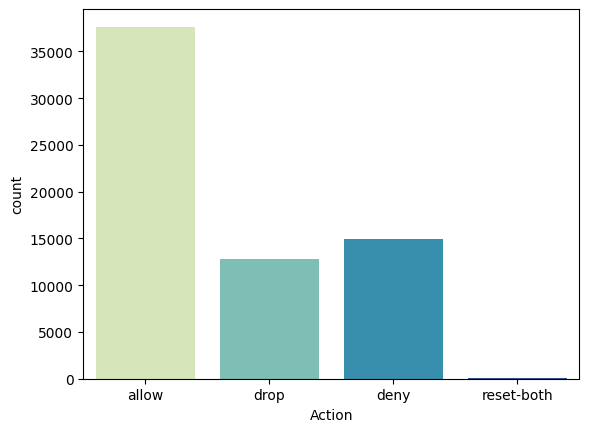

In [9]:
#Viewing the distribution of our response:
#not running for me....
sns.countplot(data=log_df,x='Action',palette='YlGnBu')
plt.show()

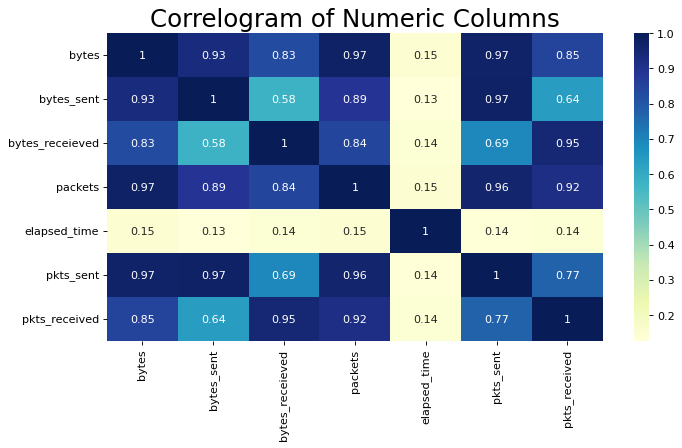

In [10]:
# Creating a correlation plot of our numeric features:

plt.figure(figsize=(10,5), dpi= 80)
corr1 = log_df.corr()
sns.heatmap(corr1,
            cmap = "YlGnBu",
            annot=True,
            annot_kws ={'size':10})    
plt.title('Correlogram of Numeric Columns', fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#this will open chrome or anything you use
import sweetviz as sv
sweet_report = sv.analyze(log_df)
sweet_report.show_html('sweet_report.html')

#for use of AutoViz
log_df.to_csv(r'../data_sets/log2_df.csv',index=False,compression=None)

#running "chart_format = 'html'" creates new folder to get charts from. 
#running "chart_format = 'bokeh'" plots interactive in notebook
#running "chart_format = 'server'" opens separately in browser

from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

av_df = AV.AutoViz(r'../data_sets/log2_df.csv', depVar='Action',chart_format='bokeh',verbose=1)

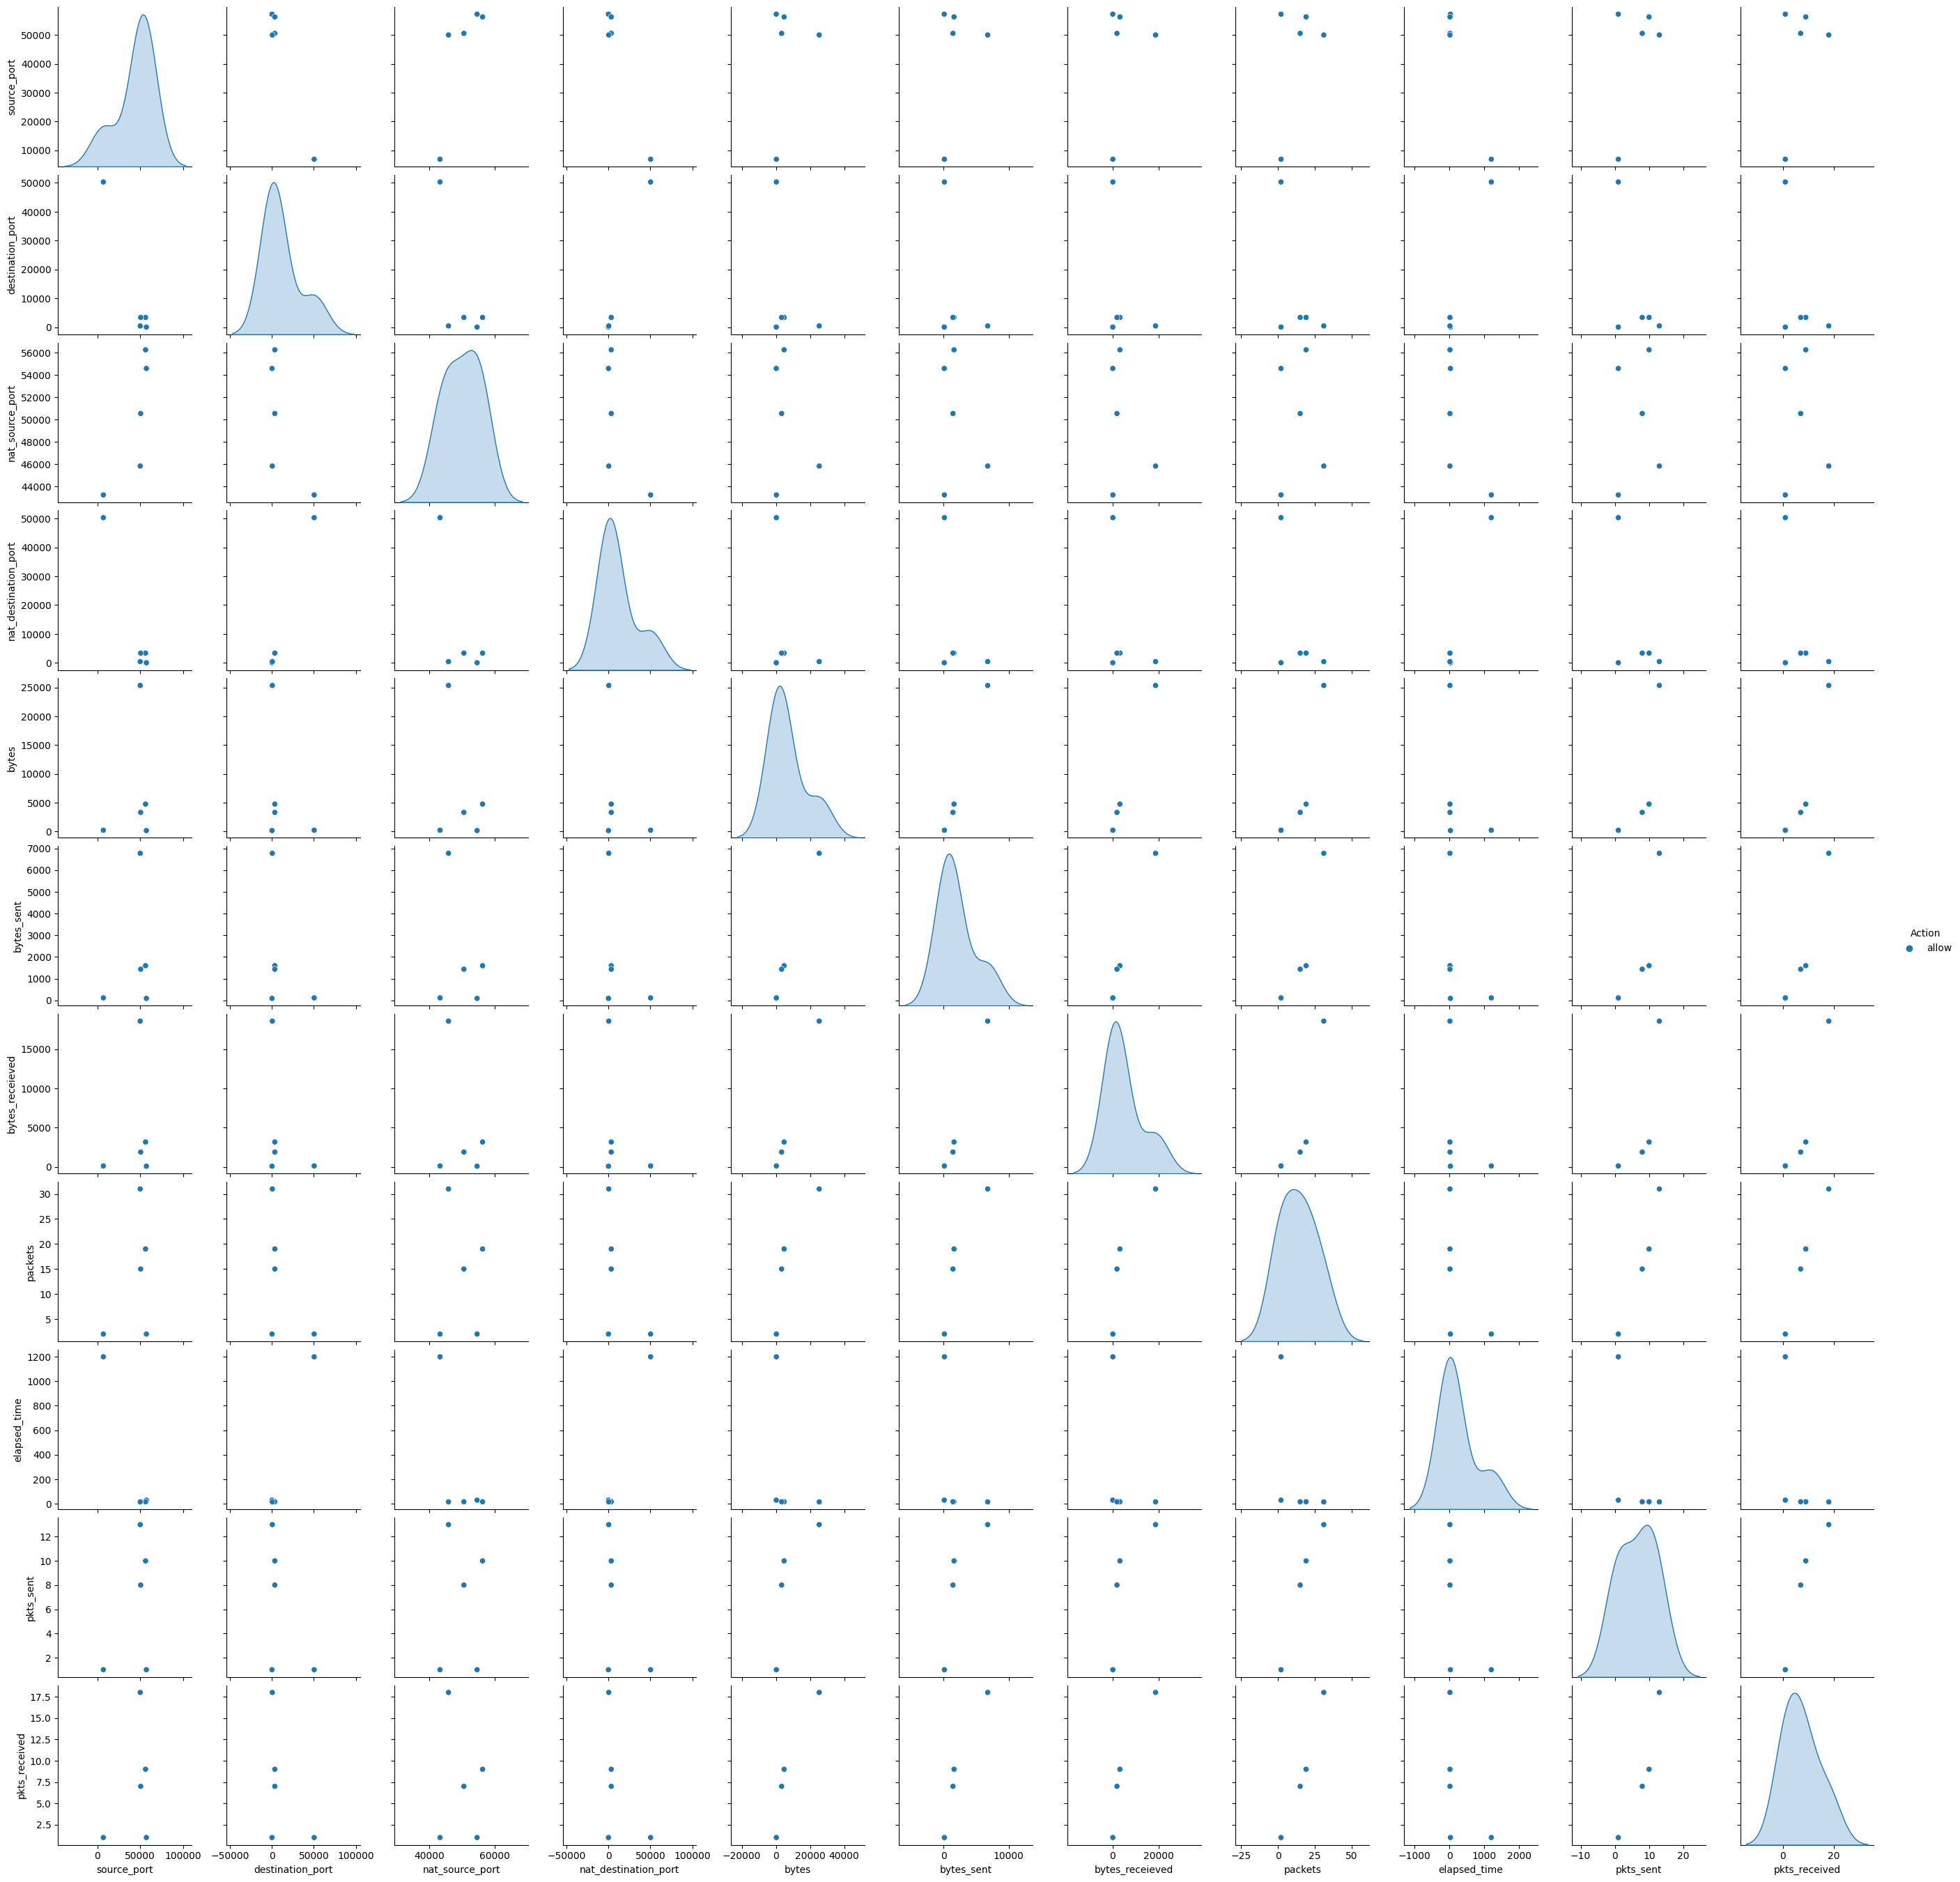

In [11]:
#Creating pairplots of our log_df dat frame to view our variable distributions:
"""
I know this isn't a report, but I would try and blow these up if I could or plot them 1 by 1
"""
sns.pairplot(log_df[0:5], hue ='Action')
plt.show()

## Re-Coding Categorical Variables:

In [12]:
"""
I talked a bit woth Britnney on this--rather than a percentage, 
I'd look at total count.  For instance if I did a 10 fold CV, 
anything with a count less than 10 would give me probelems
"""
for col in cat_df.columns:
    if cat_df[col].dtype == 'object':
        tmp = cat_df[col].value_counts()
        #print(tmp[tmp<10])
        print(f"A total of {tmp[tmp<10].shape[0]} items in {col} have counts < 10")


A total of 22321 items in source_port have counts < 10
A total of 3085 items in destination_port have counts < 10
A total of 29148 items in nat_source_port have counts < 10
A total of 2487 items in nat_destination_port have counts < 10
A total of 0 items in Action have counts < 10


In [13]:
tmp[tmp<10].index.tolist()

[]

In [14]:
#For loop to calculate the counts of each categorical variable in our cat_df DF:

for col in cat_df.columns:
    if cat_df[col].dtype == 'object':
        print(cat_df[col].value_counts()/len(cat_df)*100)

58638    1.281817
27005    0.782824
443      0.416590
57470    0.338766
49418    0.320454
           ...   
32996    0.001526
60574    0.001526
60570    0.001526
65368    0.001526
54871    0.001526
Name: source_port, Length: 22724, dtype: float64
53       23.521333
445      19.671306
443      17.829457
80        6.157297
25174     1.658732
           ...    
20009     0.001526
48608     0.001526
10016     0.001526
13384     0.001526
22455     0.001526
Name: destination_port, Length: 3273, dtype: float64
0        43.386437
48817     0.126656
58638     0.077825
50116     0.022890
7986      0.007630
           ...    
2063      0.001526
33661     0.001526
36797     0.001526
14122     0.001526
13485     0.001526
Name: nat_source_port, Length: 29152, dtype: float64
0        43.386437
53       23.033022
443      17.820302
80        6.146615
27015     0.357077
           ...    
45561     0.001526
45738     0.001526
41872     0.001526
25760     0.001526
32277     0.001526
Name: nat_destinatio

In [15]:
cat_df = log_df.select_dtypes(include=['object'])

In [16]:
"""
So I re-coded all the low counts to port 999999
"""
for col in cat_df.columns:
    counts =log_df[col].value_counts()
    lows = counts[counts<10].index
    log_df.loc[log_df[col].isin(lows),col] = 999999
    


In [17]:
log_df

,source_port,destination_port,nat_source_port,nat_destination_port,Action,bytes,bytes_sent,bytes_receieved,packets,elapsed_time,pkts_sent,pkts_received
0,999999,53,999999,53,allow,177,94,83,2,30,1,1
1,999999,3389,999999,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,999999,50321,allow,238,118,120,2,1199,1,1
3,999999,3389,999999,3389,allow,3327,1438,1889,15,17,8,7
4,999999,443,999999,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,999999,80,999999,80,allow,314,192,122,6,15,4,2
65528,999999,80,999999,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,999999,445,0,0,drop,70,70,0,1,0,1,0
65530,999999,445,0,0,drop,70,70,0,1,0,1,0


In [18]:
#Re-coding our source_port variable: 0.4

cat_df['source_port']=cat_df['source_port'].mask(cat_df['source_port'].map(cat_df['source_port'].value_counts(normalize=True)) < .00021, 'Other')
cat_df.source_port.value_counts(normalize=True, ascending=False) #Viewing results of our 'source_port' column.

999999    0.869194
Other     0.050174
58638     0.012818
27005     0.007828
443       0.004166
            ...   
54998     0.000214
56658     0.000214
49369     0.000214
43129     0.000214
49845     0.000214
Name: source_port, Length: 102, dtype: float64

In [19]:
#Re-coding our nat_source_port variable:

cat_df['nat_source_port']=cat_df['nat_source_port'].mask(cat_df['nat_source_port'].map(cat_df['nat_source_port'].value_counts(normalize=True)) < .00004, 'Other')
cat_df.nat_source_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

999999    0.563862
0         0.433864
48817     0.001267
58638     0.000778
50116     0.000229
Name: nat_source_port, dtype: float64

In [20]:
#Re-coding our destination_port variable:

cat_df['destination_port']=cat_df['destination_port'].mask(cat_df['destination_port'].map(cat_df['destination_port'].value_counts(normalize=True)) < .004, 'Other')
cat_df.destination_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

53        0.235213
445       0.196713
443       0.178295
Other     0.110419
999999    0.088857
80        0.061573
25174     0.016587
5900      0.013871
37965     0.012605
22114     0.011704
64147     0.011536
50584     0.010941
57470     0.010239
44847     0.009553
35440     0.006531
51505     0.005722
26467     0.005661
23        0.005539
56205     0.004395
30188     0.004044
Name: destination_port, dtype: float64

In [21]:
#Re-coding our nat_destination_port variable:

cat_df['nat_destination_port']=cat_df['nat_destination_port'].mask(cat_df['nat_destination_port'].map(cat_df['nat_destination_port'].value_counts(normalize=True)) < .1, 'Other')
cat_df.nat_destination_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

0        0.433864
53       0.230330
443      0.178203
Other    0.157602
Name: nat_destination_port, dtype: float64

## OHE:

In [22]:
#Grabbing categorical columns from our cat_final DF for OHE:

column_names_for_onehot = cat_df.columns[0:4]
column_names_for_onehot #Verifying all of our columns are in our variable.

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port'],
      dtype='object')

In [23]:
#Performing OHE on our categorical columns:

cat_ohe = pd.get_dummies(cat_df, columns=column_names_for_onehot, drop_first=False)

In [24]:
log_final = num_df.join(cat_ohe)
pd.set_option('display.max_columns', None)
log_final

,bytes,bytes_sent,bytes_receieved,packets,elapsed_time,pkts_sent,pkts_received,Action,source_port_0,source_port_80,source_port_123,source_port_443,source_port_993,source_port_1024,source_port_1025,source_port_1027,source_port_2267,source_port_3478,source_port_5222,source_port_5223,source_port_5588,source_port_5938,source_port_6666,source_port_6712,source_port_6881,source_port_6882,source_port_6889,source_port_8889,source_port_8999,source_port_10151,source_port_10669,source_port_11136,source_port_13285,source_port_15503,source_port_16387,source_port_17750,source_port_19473,source_port_19875,source_port_21133,source_port_25565,source_port_26900,source_port_27005,source_port_27988,source_port_30188,source_port_30960,source_port_37965,source_port_40204,source_port_42252,source_port_42298,source_port_43129,source_port_43584,source_port_44847,source_port_45682,source_port_45908,source_port_45941,source_port_45964,source_port_47910,source_port_48676,source_port_48706,source_port_48817,source_port_49001,source_port_49160,source_port_49364,source_port_49369,source_port_49418,source_port_49501,source_port_49514,source_port_49516,source_port_49531,source_port_49708,source_port_49767,source_port_49812,source_port_49845,source_port_50052,source_port_50116,source_port_50265,source_port_50470,source_port_50584,source_port_51221,source_port_51244,source_port_51413,source_port_51414,source_port_51880,source_port_52459,source_port_54280,source_port_54998,source_port_55043,source_port_55056,source_port_55179,source_port_55199,source_port_55600,source_port_55786,source_port_55836,source_port_55877,source_port_55893,source_port_56127,source_port_56388,source_port_56624,source_port_56658,source_port_56661,source_port_56703,source_port_57131,source_port_57470,source_port_57987,source_port_58638,source_port_61550,source_port_65189,source_port_65515,source_port_999999,source_port_Other,destination_port_23,destination_port_53,destination_port_80,destination_port_443,destination_port_445,destination_port_5900,destination_port_22114,destination_port_25174,destination_port_26467,destination_port_30188,destination_port_35440,destination_port_37965,destination_port_44847,destination_port_50584,destination_port_51505,destination_port_56205,destination_port_57470,destination_port_64147,destination_port_999999,destination_port_Other,nat_source_port_0,nat_source_port_48817,nat_source_port_50116,nat_source_port_58638,nat_source_port_999999,nat_destination_port_0,nat_destination_port_53,nat_destination_port_443,nat_destination_port_Other
0,177,94,83,2,30,1,1,allow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,4768,1600,3168,19,17,10,9,allow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
2,238,118,120,2,1199,1,1,allow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
3,3327,1438,1889,15,17,8,7,allow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,25358,6778,18580,31,16,13,18,allow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## SVM Modeling

In [25]:
#Setting a seed:

np.random.seed(1234)

In [26]:
#Splitting feature columns from our response:

X = log_final.loc[:, log_final.columns != 'Action']
y = log_final['Action']

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0)

In [28]:
#Scaling data:

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) 
#  X_test = scaler.fit_transform(X_test) 
# Naughty Naughty!
# You want to try out how your training set did
# so you use THAT transform on all test data!
X_test = scaler.transform(X_test) 

# Fitting SVM models:


# SVM with Linear kernel:


In [29]:
cs = [0.3,0.4,0.5,0.6,0.7]
for idx , c in enumerate(cs,start=0):
    globals()[f'linear_{idx}'] = svm.SVC(kernel='linear', C=c, cache_size=2000).fit(X_train, y_train)
    globals()[f'linear_pred_{idx}'] = globals()[f'linear_{idx}'].predict(X_test)


              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.99      0.99      0.99      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.99      0.99      0.99      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.

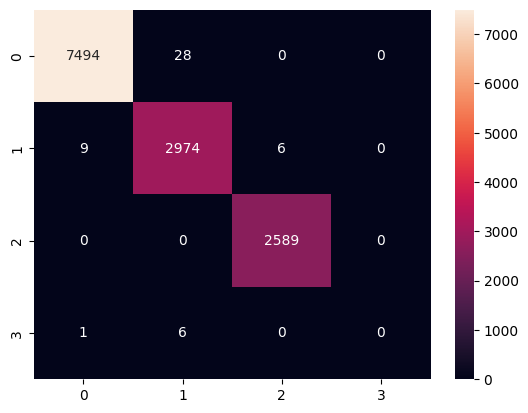

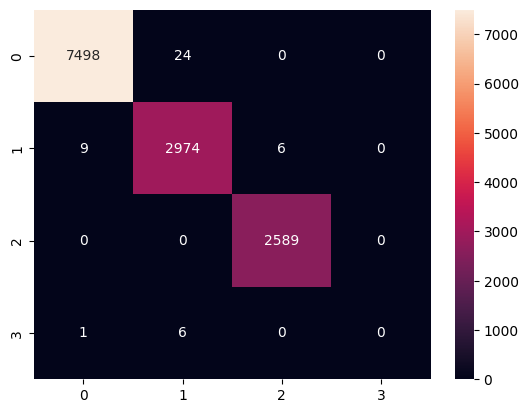

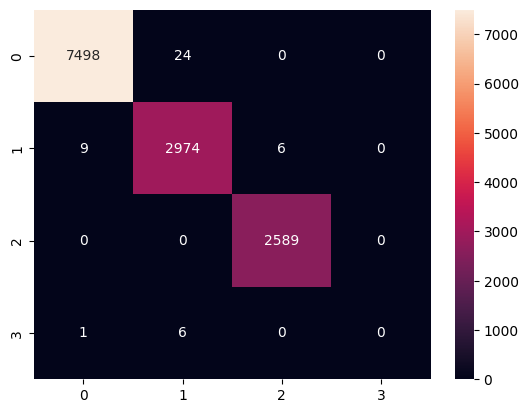

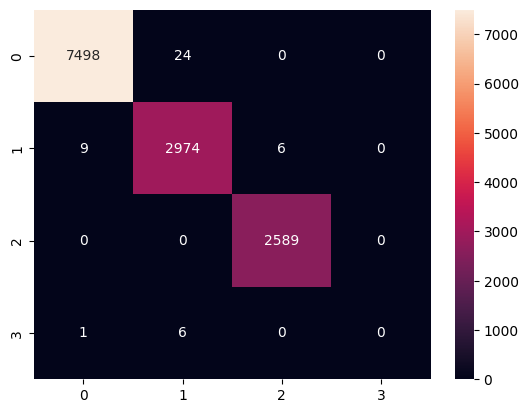

In [30]:
for i in range(0,4):
    print(classification_report(y_test,globals()[f'linear_pred_{i}']));
    globals()[f'linear_cm_{i}'] = confusion_matrix(y_test, globals()[f'linear_pred_{i}'])
    plt.figure()
    sns.heatmap(globals()[f'linear_cm_{i}'], annot=True, fmt='d')

# SVM with Polnomial kernel:


In [31]:
cs = [0.3,0.4,0.5,0.6,0.7]
for idx , c in enumerate(cs,start=0):
    globals()[f'poly_{idx}'] = svm.SVC(kernel='poly', C=c, cache_size=2000).fit(X_train, y_train)
    globals()[f'poly_pred_{idx}'] = globals()[f'poly_{idx}'].predict(X_test)


              precision    recall  f1-score   support

       allow       0.98      1.00      0.99      7522
        deny       0.99      0.94      0.96      2989
        drop       0.99      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           0.98     13107
   macro avg       0.74      0.73      0.74     13107
weighted avg       0.98      0.98      0.98     13107

              precision    recall  f1-score   support

       allow       0.98      1.00      0.99      7522
        deny       0.99      0.94      0.97      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           0.98     13107
   macro avg       0.74      0.73      0.74     13107
weighted avg       0.98      0.98      0.98     13107

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.

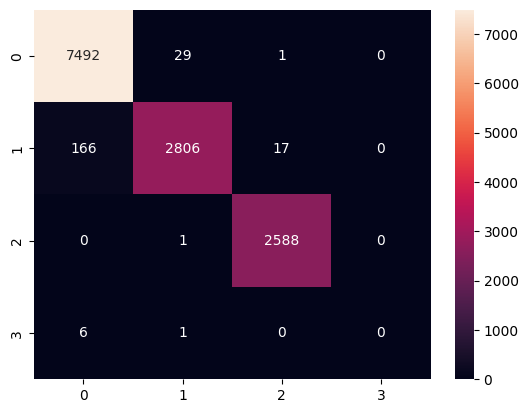

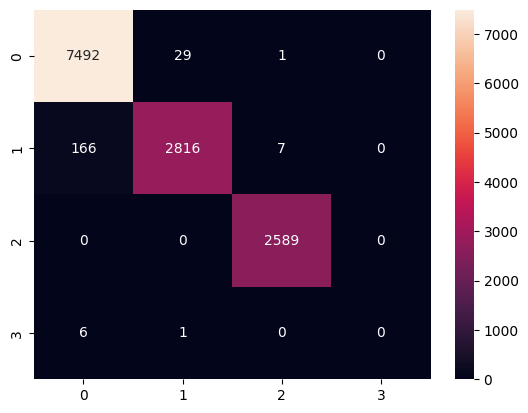

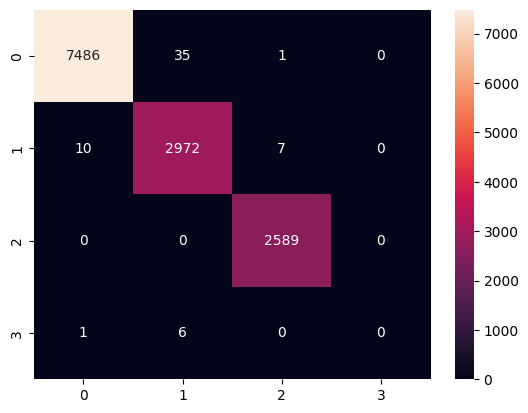

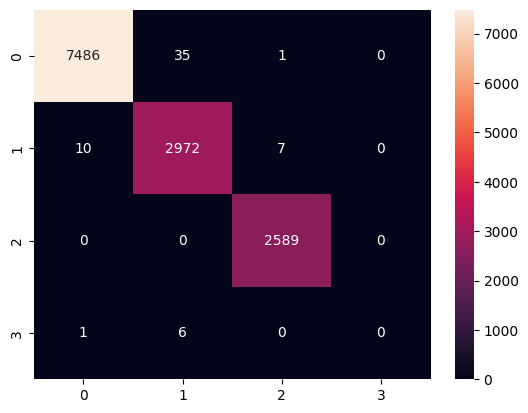

In [32]:
for i in range(0,4):
    print(classification_report(y_test,globals()[f'poly_pred_{i}']))
    globals()[f'poly_cm_{i}'] = confusion_matrix(y_test, globals()[f'poly_pred_{i}'])
    plt.figure()
    sns.heatmap(globals()[f'poly_cm_{i}'], annot=True, fmt='d')

*** 
# Begin Vow Pal Wabbit Modeling:

In [33]:
vw_df = log_df.copy()

In [34]:
action_vals = list(vw_df['Action'].unique())


vw_df['Action'].replace(action_vals,
                        [1, 2, 3, 4],
                        inplace=True
                        )

vw_df['Action'].unique()

array([1, 2, 3, 4])

In [35]:
vw_X = list(vw_df.columns[vw_df.columns != 'Action'])
vw_y = list(vw_df.columns[vw_df.columns == 'Action'])

In [36]:
vpw_train, vpw_test = train_test_split(
                                        vw_df, 
                                        test_size=0.2,
                                        random_state= 0
                                      )

In [37]:
train_converter = DFtoVW.from_column_names(df=vpw_train, y=vw_y, x=vw_X)
test_converter = DFtoVW.from_column_names(df=vpw_test, y=vw_y, x=vw_X)

In [38]:
test = test_converter.convert_df()
train = train_converter.convert_df()

In [39]:
test[:1]

['1 | source_port=999999 destination_port=53 nat_source_port=999999 nat_destination_port=53 bytes:197 bytes_sent:102 bytes_receieved:95 packets:2 elapsed_time:33 pkts_sent:1 pkts_received:1']

In [40]:
# don't forget your correct loss!  logistic
# also need to add the oaa label
# add in your regularization
# to find your 'best' fit use something like logloss on test set
l2s = [1,.1,.001,.0001,.00001,.000001,0.0000001]
for idx,l in enumerate(l2s):
    globals()[f'model_{idx}'] = Workspace(P=10,enable_logging=True, loss_function='hinge', oaa=4, learning_rate = 0.5, l2=l,probabilities=False)

for t in train:
    model_0.learn(t)

for t in train:
    model_1.learn(t)

for t in train:
    model_2.learn(t)

for t in train:
    model_3.learn(t)

for t in train:
    model_4.learn(t)

for t in train:
    model_5.learn(t)

for t in train:
    model_6.learn(t)

In [41]:
predictions_0 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class0 = model_0.predict(p,prediction_type=4)
    predictions_0.append(predicted_class0)


predictions_1 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class1 = model_1.predict(p,prediction_type=4)
    predictions_1.append(predicted_class1)


predictions_2 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class2 = model_2.predict(p,prediction_type=4)
    predictions_2.append(predicted_class2)


predictions_3 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class3 = model_3.predict(p,prediction_type=4)
    predictions_3.append(predicted_class3)


predictions_4 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class4 = model_4.predict(p,prediction_type=4)
    predictions_4.append(predicted_class4)

predictions_5 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class5 = model_5.predict(p,prediction_type=4)
    predictions_5.append(predicted_class5)

predictions_6 = []
for p in test:
    #type 7 gets you probabilities, type 4 gets you class
    # if you use "4", set probabilities to 'False' above
    predicted_class6 = model_6.predict(p,prediction_type=4)
    predictions_6.append(predicted_class6)

In [42]:
set(predictions_4)

{1, 2, 3, 4}

In [43]:
actuals_0 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_0.append(actual)

actuals_1 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_1.append(actual)

actuals_2 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_2.append(actual)

actuals_3 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_3.append(actual)

actuals_4 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_4.append(actual)

actuals_5 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_5.append(actual)

actuals_6 = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals_6.append(actual)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7522
           2       0.20      1.00      0.33      2589
           3       0.00      0.00      0.00      2989
           4       0.00      0.00      0.00         7

    accuracy                           0.20     13107
   macro avg       0.05      0.25      0.08     13107
weighted avg       0.04      0.20      0.07     13107

              precision    recall  f1-score   support

           1       1.00      0.98      0.99      7522
           2       0.45      1.00      0.62      2589
           3       1.00      0.00      0.00      2989
           4       0.00      0.00      0.00         7

    accuracy                           0.76     13107
   macro avg       0.61      0.50      0.41     13107
weighted avg       0.89      0.76      0.69     13107

              precision    recall  f1-score   support

           1       1.00      0.99      0.99      7522
           2       0.

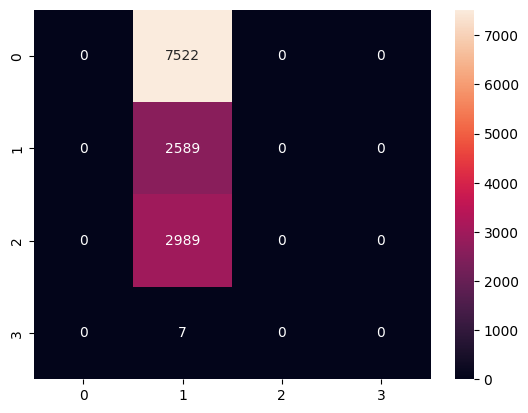

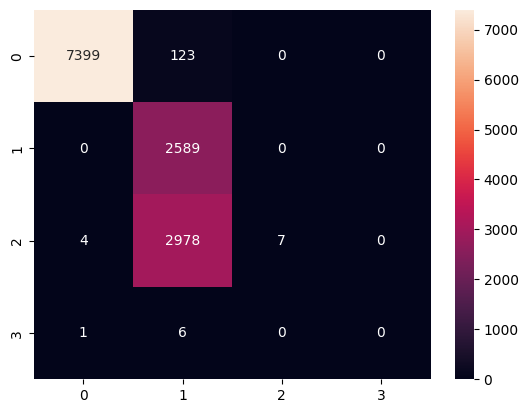

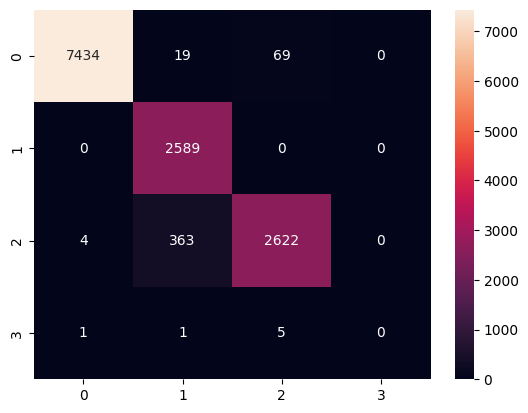

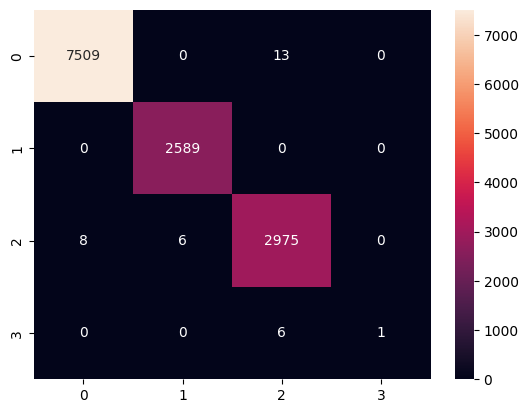

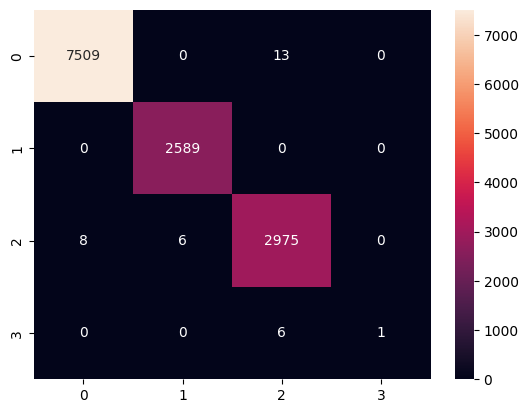

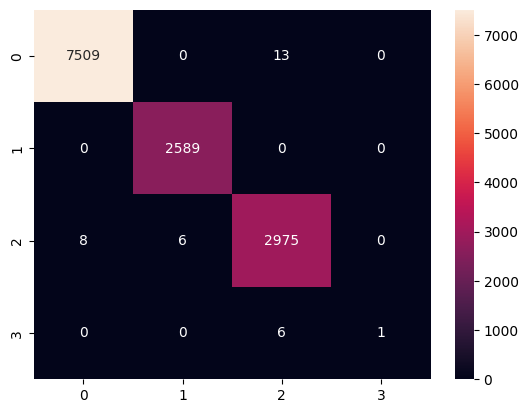

In [55]:
for i in range(0,6):
    print(classification_report(globals()[f'actuals_{i}'],globals()[f'predictions_{i}']))
    globals()[f'cm_{i}'] = confusion_matrix(globals()[f'actuals_{i}'],globals()[f'predictions_{i}'])
    plt.figure()
    sns.heatmap(globals()[f'cm_{i}'], annot=True, fmt='d')

In [54]:
model_0.get_log()[:20]


['using l2 regularization = 1',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  '
 'current',
 'loss     last          counter         weight          label        predict '
 'features',
 '0.600000 0.600000           10           10.0              1              '
 '1       12',
 '0.700000 0.800000           20           20.0              3              '
 '1        9',
 '0.666667 0.600000           30           30.0              3              '
 '3        9',
 '0.675000 0.700000           40           40.0              1              '
 '1       12',
 '0.620000 0.400000           50           50.0              2              '
 '1        9',
 '0.616667 0.600000           60           60.0           

In [46]:
model_1.get_log()[:20]


['using l2 regularization = 0.1',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.200000 0.200000           10           10.0              1              1       12',
 '0.250000 0.300000           20           20.0              3              1        9',
 '0.233333 0.200000           30           30.0              3              3        9',
 '0.250000 0.300000           40           40.0              1              1       12',
 '0.260000 0.300000           50           50.0              2              1        9',
 '0.250000 0.200000           60           60.0              1              1       

In [47]:
model_3.get_log()[:20]


['using l2 regularization = 0.0001',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.200000 0.200000           10           10.0              1              1       12',
 '0.200000 0.200000           20           20.0              3              3        9',
 '0.200000 0.200000           30           30.0              3              3        9',
 '0.200000 0.200000           40           40.0              1              1       12',
 '0.160000 0.000000           50           50.0              2              2        9',
 '0.133333 0.000000           60           60.0              1              1    

In [48]:
model_4.get_log()[:20]


['using l2 regularization = 1e-05',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.200000 0.200000           10           10.0              1              1       12',
 '0.200000 0.200000           20           20.0              3              3        9',
 '0.200000 0.200000           30           30.0              3              3        9',
 '0.200000 0.200000           40           40.0              1              1       12',
 '0.160000 0.000000           50           50.0              2              2        9',
 '0.133333 0.000000           60           60.0              1              1     

In [49]:
model_5.get_log()[:20]

['using l2 regularization = 1e-06',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.200000 0.200000           10           10.0              1              1       12',
 '0.200000 0.200000           20           20.0              3              3        9',
 '0.200000 0.200000           30           30.0              3              3        9',
 '0.200000 0.200000           40           40.0              1              1       12',
 '0.160000 0.000000           50           50.0              2              2        9',
 '0.133333 0.000000           60           60.0              1              1     

In [50]:
model_6.get_log()[:20]

['using l2 regularization = 1e-07',
 'using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'Enabled reductions: gd, scorer-identity, oaa',
 'Input label = multiclass',
 'Output pred = multiclass',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 '0.200000 0.200000           10           10.0              1              1       12',
 '0.200000 0.200000           20           20.0              3              3        9',
 '0.200000 0.200000           30           30.0              3              3        9',
 '0.200000 0.200000           40           40.0              1              1       12',
 '0.160000 0.000000           50           50.0              2              2        9',
 '0.133333 0.000000           60           60.0              1              1     